This notebook includes an analysis covering EDA with a primary focus on understanding variable distributions. Furthermore, it 

incorporates Feature Engineering techniques, encompassing the creation of new features for improved pattern recognition, the 

transformation of existing features to enhance modeling suitability, and the handling of duplicate data and other text 

preprocessing tasks, including vectorization to prepare text for feeding into machine learning models.

# 1. Import Libraries and Reading the Data

In [62]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Preprocessing
import re # Handling HTML tags and URLs
import nltk
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup #HTML tags
from contractions import contractions_dict, fix
import spacy
from spacy.lang.en import English
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer # Stemming or lemmatization
import string # remove punctuation
import contractions


# Download NLTK stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.data.path.append("C:\\Users\\tmost/nltk_data")


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Utilities
from tqdm import tqdm # progeress bar

# Jupyter Notebook Specific
%matplotlib inline

# Warning Settings
import warnings
warnings.filterwarnings("ignore")

# Pickle for Serialization
import pickle

# spilit data
from sklearn.model_selection import train_test_split

# Vectorization for feature extraction
from sklearn.feature_extraction.text import CountVectorizer #converting a collection of text doc to a matrix of token counts.

from scipy.stats import entropy


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tmost\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
## Reading the data

data = pd.read_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/Reviews.csv')
print(data.shape)

(568454, 10)


## 2. EDA

### Data Understanding

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Check missing values

In [5]:
data.isnull().any()

Id                        False
ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool

### Check duplicate data

#### across rows

In [6]:
anyduplicate_row = data.duplicated().any()  # checks for duplicated rows across all columns.
anyduplicate_row

False

#### Check for duplicated data within individual columns

In [7]:
for column in data.columns:
    column_has_duplicates = data[column].duplicated().any()
    print(f"Column '{column}' has duplicates: {column_has_duplicates}")

Column 'Id' has duplicates: False
Column 'ProductId' has duplicates: True
Column 'UserId' has duplicates: True
Column 'ProfileName' has duplicates: True
Column 'HelpfulnessNumerator' has duplicates: True
Column 'HelpfulnessDenominator' has duplicates: True
Column 'Score' has duplicates: True
Column 'Time' has duplicates: True
Column 'Summary' has duplicates: True
Column 'Text' has duplicates: True


In [8]:
duplicate_entry = data[data.duplicated(subset=['UserId','ProfileName','Time','Text'],keep=False)]
duplicate_entry.shape
#keep false, marked the duplicated elements

(232415, 10)

In [9]:
duplicate_entry.sample(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
217076,217077,B003X0TRGW,A2GC5JELY3N07V,bman,0,0,4,1317600000,Beats Cinnamon Toast Crunch,"Looking for a change, I decided to pick up a b..."
496562,496563,B0029NIPSA,A2T5VEAFT6PUH3,"J. Hollister ""Judy says""",0,0,5,1337040000,Lamby delicious,Our westies love the Caesar Canine Cuisine foo...
359383,359384,B007M832YY,A3T0OTH5072YRE,"M. Reynard ""kairosdreaming""",0,0,3,1337299200,Pop Chips Barbeque Potato Chips,"My local store was running a special on these,..."


### Drop Duplicated data

- During basic data cleaning, we identified redundant entries where users provided the same review for different products simultaneously. To address this, we'll keep only the first occurrence and remove subsequent duplicates.

In [10]:
data.shape  # original dataset

(568454, 10)

In [11]:
df = data.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep='first',inplace=False)
df.shape

(393933, 10)

If some columns are being considered in the removal of duplicates, it because of the values in these columns are being used to identify and distinguish between duplicate rows. e.g.,, the subset of columns ('UserId', 'ProfileName', 'Time', and 'Text') is crucial in determining whether two rows are considered duplicates.

In [12]:
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(data.shape[0]*1.0))*100}')

Remaining data is 69.29901100176971


- Now our data points got reduced to about 69%.

## 3.Feature Engineering

- Create new columnns **"usefulness"** by analyzing "HelpfulnessNumerator" and "HelpfulnessDenominator"

- What are the differences?
    
    
- HelpfulnessNumerator = Represent the number of people who found the review helpful.


- HelpfulnessDenominator = Represent the number of people who found the review, whether they found it j´helpful or not.

In [13]:
df['usefulness'] = df['HelpfulnessNumerator']/df['HelpfulnessDenominator']
df.usefulness[105:110] # randomly check the values

106    0.25
107    1.00
108    1.00
109     NaN
110    1.00
Name: usefulness, dtype: float64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393933 entries, 0 to 568453
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      393933 non-null  int64  
 1   ProductId               393933 non-null  object 
 2   UserId                  393933 non-null  object 
 3   ProfileName             393922 non-null  object 
 4   HelpfulnessNumerator    393933 non-null  int64  
 5   HelpfulnessDenominator  393933 non-null  int64  
 6   Score                   393933 non-null  int64  
 7   Time                    393933 non-null  int64  
 8   Summary                 393930 non-null  object 
 9   Text                    393933 non-null  object 
 10  usefulness              209310 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 44.1+ MB


>> Categorized the "usefulness" based on certain conditions


- If the value is greater than 0.75, it appends ">75%" to the 'usefulness' list.


- If the value is less than 0.25, it appends "<25%" to the 'usefulness' list.


- If the value is between 0.25 and 0.75 (inclusive), it appends "25-75%" to the 'usefulness' list.


- If none of the above conditions are met, it appends "useless" to the 'usefulness' list.

In [15]:
usefulness = [] # this columns convert from float to object
for i in df['usefulness']:
    if i > 0.75:
        usefulness.append(">75%")
    elif i < 0.25:
        usefulness.append("<25%")
    elif i >= 0.25 and i <= 0.75:
        usefulness.append("25-75%")
    else:
        usefulness.append("useless")
df['usefulness']  = usefulness  

In [16]:
print(df.shape)
df.columns

(393933, 11)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'usefulness'],
      dtype='object')

### Distribution of usefulness

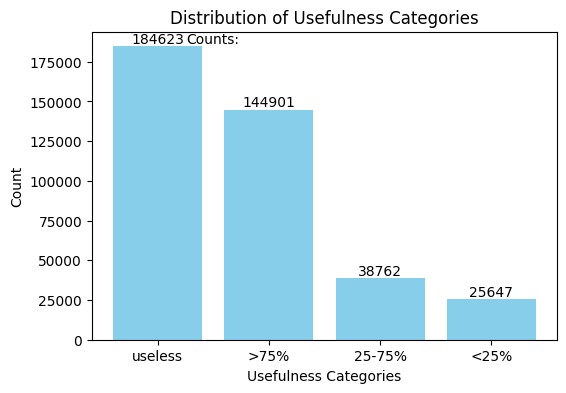

In [17]:
category_counts = df['usefulness'].value_counts() # usefulness categorical

# Plotting with adjustments
plt.figure(figsize=(6, 4)) 
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Usefulness Categories')
plt.ylabel('Count')
plt.title('Distribution of Usefulness Categories')
plt.text(0.5, max(category_counts.values) + 5, 'Counts:', horizontalalignment='center', verticalalignment='bottom', fontsize=10)
for i, count in enumerate(category_counts.values):
    plt.text(i, count + 2, str(count), horizontalalignment='center', verticalalignment='bottom', fontsize=10)

plt.show()

- provides a comparative analysis of 'usefulness' within different 'Score' categories using a specialized count plot

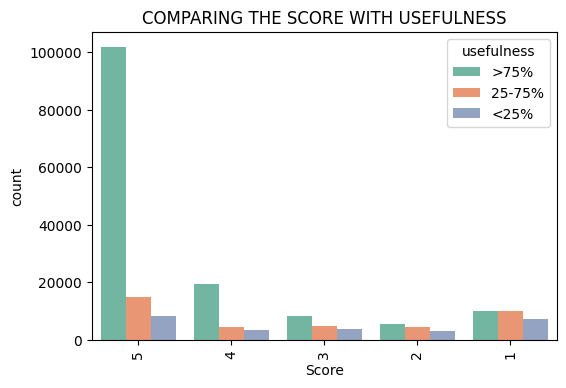

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(x='Score',data=df,hue='usefulness',hue_order=['>75%','25-75%','<25%'],order=[5,4,3,2,1],palette="Set2")
plt.xticks(rotation=90,fontsize=10)
plt.title('COMPARING THE SCORE WITH USEFULNESS')
plt.show()

- Create a new column **'word_count'** containing the word count for each review text. This can be useful for analyzing and understanding the length or complexity of the reviews in terms of the number of words.

In [19]:
word_count = []
for i in df['Text']:
    word_count.append(len(i.split()))
df['word_count'] = word_count    

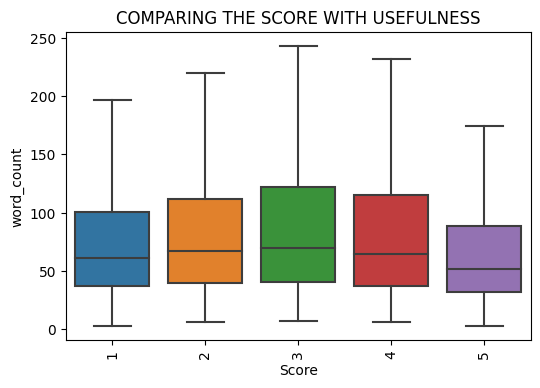

In [20]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Score',y='word_count',data=df,showfliers=False)
plt.xticks(rotation=90,fontsize=10)
plt.title('COMPARING THE SCORE WITH USEFULNESS')
plt.show()

###  Count of Reviews by stars

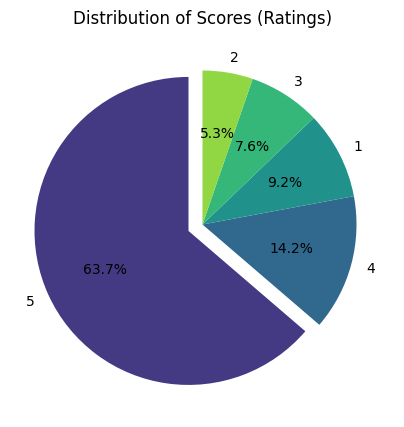

In [21]:
# Assuming 'Score' is the column containing ratings in your DataFrame
plt.figure(figsize=(5, 5))

# Sort the DataFrame by 'Score'
df_sorted = df.sort_values(by='Score')

# Define a custom color palette
custom_palette = sns.color_palette("viridis", n_colors=len(df_sorted['Score'].unique()))

score_counts = df_sorted['Score'].value_counts()
labels = score_counts.index
explode = (0.1, 0, 0, 0, 0)  # Explode the first slice (optional)

plt.pie(score_counts, labels=labels, colors=custom_palette, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Distribution of Scores (Ratings)')
plt.show()



- Create new columns **"Sentiment"** based on the values in the existing 'Score' columns. The logic is a s follows:
    
    
    - If the 'Score' is greater than 3, the corresponding sentiment is set to 'positive'.
    
    
    - If the 'Score' is less than 3, the sentiment is set to 'negative'.
    
    
    - If the 'Score' is exactly 3, the sentiment is set to 'not'.
    

In [22]:
sentiment = []
for i in df['Score']:
    if i > 3:
        sentiment.append('positive')
    elif i < 3:
        sentiment.append('negative')
    else:
        sentiment.append('not')
df['sentiment'] = sentiment   

In [23]:
df.sentiment.head()

0    positive
1    negative
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

In [24]:
positive_rev = df[df.sentiment=='positive']
positive_rev.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,usefulness,word_count,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,>75%,48,positive
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,>75%,94,positive


In [25]:
Negative_rev = df[df.sentiment=='negative']
Negative_rev.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,usefulness,word_count,sentiment
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,useless,31,negative
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,>75%,41,negative


**WordCloud Class**:


The WordCloud class from the wordcloud library generates visual representations of text data, sizing words based on frequency. It allows customization of parameters like image size, color schemes, and fonts.


**STOPWORDS**:

STOPWORDS, a set of common words (e.g., "the," "and," "is"), are often excluded in text analysis as they contribute little meaning. In WordCloud, the stopwords parameter excludes specific words from the generated word cloud.

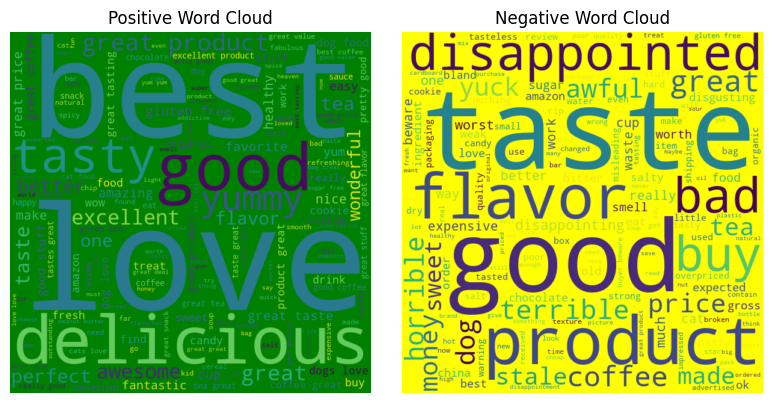

In [26]:
# Positive Word Cloud
comment_words_positive = ''
stopwords_wc = set(STOPWORDS)

for val in positive_rev['Summary']:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words_positive += " ".join(tokens) + " "

wordcloud_positive = WordCloud(width=600, height=600,
                               background_color='green',
                               stopwords=stopwords_wc,
                               min_font_size=10).generate(comment_words_positive)

# Negative Word Cloud
comment_words_negative = ''
for val in Negative_rev['Summary']:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words_negative += " ".join(tokens) + " "

wordcloud_negative = WordCloud(width=600, height=600,
                               background_color='yellow',
                               stopwords=stopwords_wc,
                               min_font_size=10).generate(comment_words_negative)

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Positive Word Cloud
axes[0].imshow(wordcloud_positive, interpolation='bilinear')
axes[0].set_title('Positive Word Cloud')
axes[0].axis('off')

# Negative Word Cloud
axes[1].imshow(wordcloud_negative, interpolation='bilinear')
axes[1].set_title('Negative Word Cloud')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4.Preprocessing the Text Data

1. lowercasing


2. Removing Punctuation


3. Tokenization  -> Break the text into individual words or tokens.


4. Removing Stopwords


5. Stemming or lemmatization


6. handling Numerical values


7. Handeling HTML Tags and URLs


8. Handling Special Charachters


9. Handling Emotions and Special Characters


10. Text Vectorization  -> Convert text into numerical vectors. e.g., Bag of Words or other methods

In [28]:
# English Stopwords
stopwords_set = set(stopwords.words('english'))

# Make the text lower case, tokenize, and remove stopwords
def remove_stopwords(text):
    text = text.lower()
    word_tokens = word_tokenize(text)
    text = ' '.join(word for word in word_tokens if word not in stopwords_set)
    return text


preprocessed_reviews = [] # Initialize with empty list to store preprocessed reviews 

# tqdm is for printing the status bar
for sentence in tqdm(df['Text'].values):
    # Remove URLs
    sentence = re.sub(r"http\S+", "", sentence)
    # Remove HTML tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    # Decontract text - Use contractions.fix from the contractions library
    sentence = contractions.fix(sentence)
    # Remove extra spaces and numbers
    sentence = re.sub(r"\S*\d\S*", "", sentence).strip()
    # Remove non-alphabetic characters
    sentence = re.sub(r'[^A-Za-z]+', ' ', sentence)
    # Lower case and remove stop words
    sentence = remove_stopwords(sentence)
    # Append the preprocessed sentence to the list
    preprocessed_reviews.append(sentence.strip())



100%|█████████████████████████████████████████████████████████████████████████| 393933/393933 [06:45<00:00, 972.57it/s]


In [32]:
preprocessed_reviews[1000]

'love cereal taste good good pity find cereal local supermarkets brands match'

In [53]:
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")


✘ No compatible package found for 'en_core_web_lm' (spaCy v3.7.2)



SystemExit: 1

In [130]:
samid = 3550
print(preprocessed_reviews[samid])
nlp_sp = spacy.load('en_core_web_sm')
doc = nlp_sp(preprocessed_reviews[samid])
keep = []
remove = []
for i,token in enumerate(doc):
    if token.pos_ in ('PROPN'):
        remove.append(token)
    elif token.pos_ in ('ADJ','NOUN','VERB'):
        keep.append(token)
    #for j in range(i+1,len(doc)):
    #    if doc[j].pos_ == 'ADJ':
    #        noun_adj_pairs.append((token,doc[j]))
    #        break
print('KEEP:',keep)
print('REM',remove)
print('SUMMARY:',df['Summary'][samid])

original description order said assorted chocolates got weeks later one pack white chocolates least desirable worth bother returning even prime might better buying local store cheaper price see get
I have tried all of these nuts and they are fantastic.  I highly recommend them as a snack which is not only healthy, but tasty.  The mulberries combined with chocolate are amazing.
KEEP: [fantastic, healthy, tasty, amazing]
REM []
SUMMARY: What a great combo of flavors.


In [103]:
ps = PorterStemmer()

# Apply stemming
def stemming(text):
    word_tokens = word_tokenize(text)
    text = ' '.join(ps.stem(word) for word in word_tokens)
    return text

preprocessed_reviews_stemmed = []
for sentence in tqdm(preprocessed_reviews):
    preprocessed_reviews_stemmed.append(stemming(sentence))
    

100%|█████████████████████████████████████████████████████████████████████████| 393933/393933 [08:40<00:00, 757.44it/s]


In [ ]:
def tag_sel(text):#
    word_tokens = nlp_sp(text)
    text = ' '.join(str(word) for word in word_tokens if word.pos_ in ('ADJ','NOUN','VERB','ADV'))
    return text


preprocessed_reviews_tag = []
for sentence in tqdm(preprocessed_reviews):
    preprocessed_reviews_tag.append(tag_sel(sentence))
    
    

 86%|█████████████████████████████████████████████████████████████▉          | 338990/393933 [1:08:16<11:19, 80.84it/s]

In [105]:
preprocessed_reviews_stemmed[10]

'know cactu tequila uniqu combin ingredi flavour hot sauc make one kind pick bottl trip brought back home us total blown away realiz simpli could find anywher citi bum magic internet case sauc ecstat love hot sauc mean realli love hot sauc want sauc tastelessli burn throat grab bottl tequila picant gourmet de inclan realiz tast never want use sauc thank person incred servic'

In [ ]:
# Print some examples of the preprocessed text
for i in range(3):
    print("Original Text:")
    print(df['Text'].values[i])
    print("\nPreprocessed Text:")
    print(preprocessed_reviews[i])
    print("\n" + "="*50 + "\n")


In [95]:
# Create a CountVectorizer object
bow = CountVectorizer(max_features=500) #The choice of the value for max_features depends on the size of your dataset,

# Fit and transform the training data
bow_model = bow.fit_transform(preprocessed_reviews)

In [106]:
# Create a CountVectorizer object
bow_stem = CountVectorizer(max_features=500) #The choice of the value for max_features depends on the size of your dataset,

# Fit and transform the training data
bow_model_stem = bow_stem.fit_transform(preprocessed_reviews_stemmed)

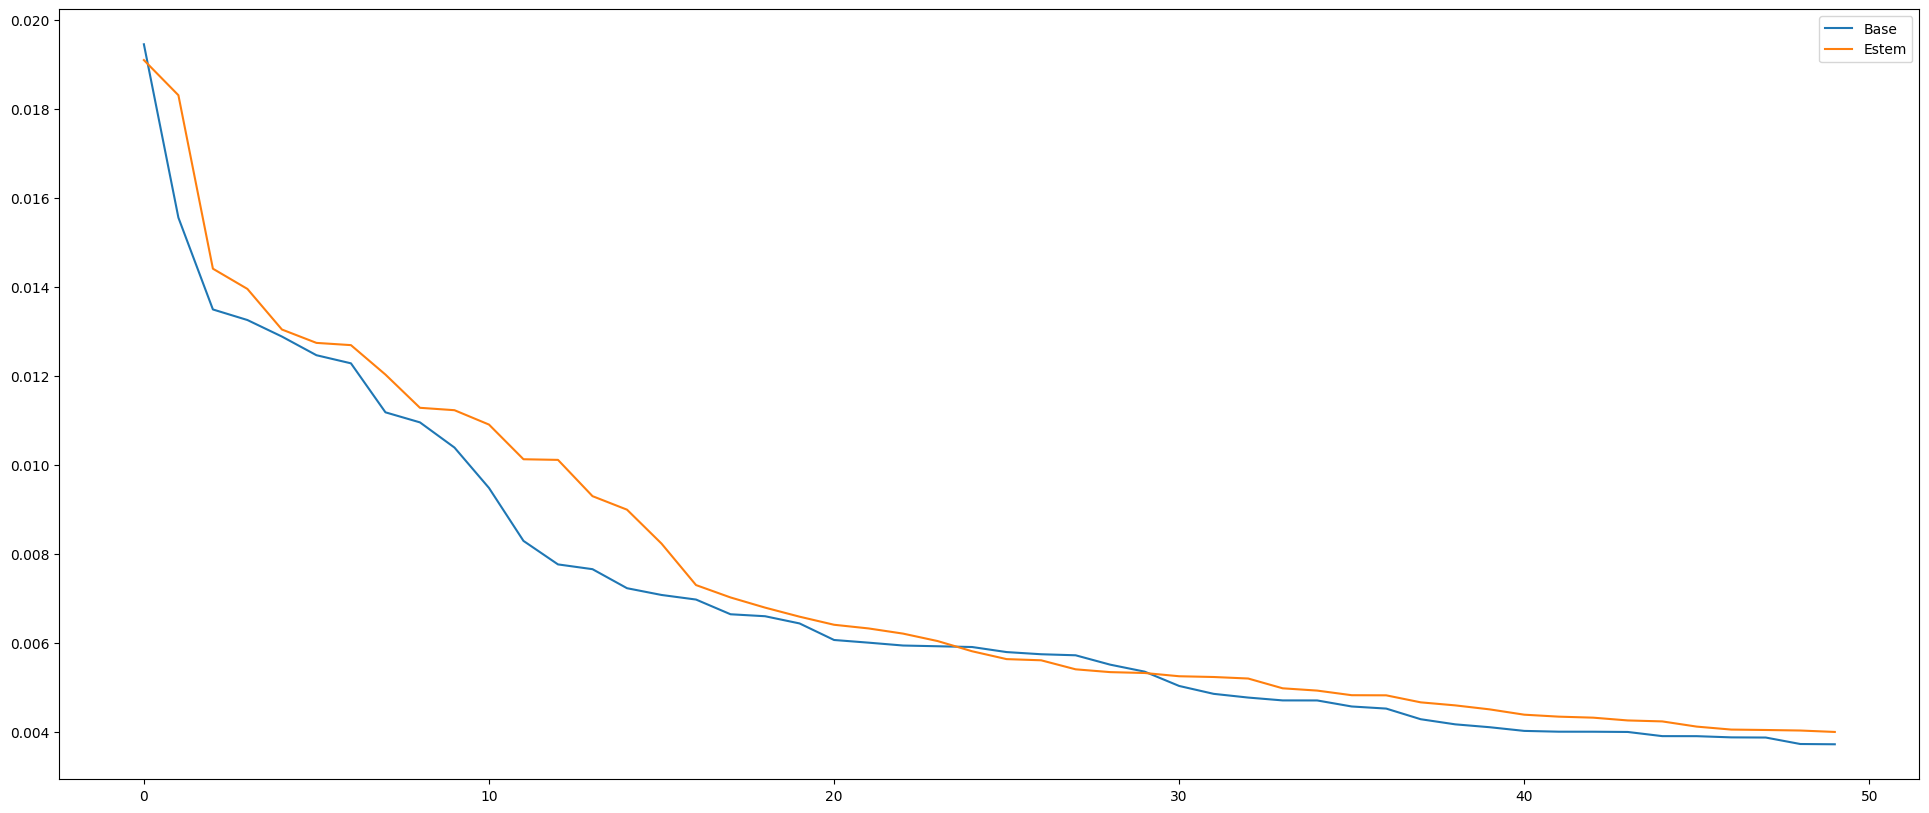

In [123]:
fig, ax1 = plt.subplots(1,1, figsize = (24, 10))

ax1.plot(np.transpose(-np.sort(-np.sum(bow_model,axis=0))/np.sum(bow_model))[0:50])
ax1.plot(np.transpose(-np.sort(-np.sum(bow_model_stem,axis=0))/np.sum(bow_model_stem))[0:50])

#ax1.set_title('Base')
plt.legend(['Base','Estem'])
#ax2.set_title('Base Pre-Proc + Stem')



In [97]:
sorted_terms = bow.get_feature_names_out(bow_model)[np.argsort(np.sum(bow_model,axis=0))]

In [110]:
sorted_terms_stem = bow_stem.get_feature_names_out(bow_model_stem)[np.argsort(np.sum(bow_model_stem,axis=0))]

In [111]:
print('Base Pre-Proc:',sorted_terms[0,-50:])
print('Base Pre-Proc Stem:',sorted_terms_stem[0,-50:])

Base Pre-Proc: ['store' 'think' 'free' 'cup' 'way' 'dog' 'bag' 'box' 'bought' 'drink'
 'made' 'sweet' 'found' 'used' 'could' 'water' 'first' 'sugar' 'eat'
 'chocolate' 'try' 'better' 'even' 'tried' 'well' 'make' 'find' 'best'
 'price' 'buy' 'little' 'time' 'also' 'use' 'amazon' 'much' 'food'
 'really' 'get' 'love' 'tea' 'coffee' 'flavor' 'product' 'would' 'great'
 'one' 'taste' 'good' 'like']
Base Pre-Proc Stem: ['could' 'year' 'packag' 'want' 'first' 'look' 'sweet' 'day' 'water'
 'sugar' 'mix' 'box' 'chocol' 'better' 'cup' 'go' 'store' 'best' 'even'
 'well' 'bag' 'dog' 'drink' 'find' 'littl' 'also' 'price' 'amazon' 'much'
 'order' 'eat' 'realli' 'time' 'buy' 'food' 'make' 'get' 'tea' 'coffe'
 'would' 'tri' 'great' 'love' 'one' 'use' 'product' 'good' 'flavor' 'tast'
 'like']


In [99]:
dense_x_train = bow_model.todense()
word_entropy = np.zeros((bow_model.shape[1],1))
for i in range(bow_model.shape[1]):
    word_entropy[i] = entropy(dense_x_train[:,i]/np.sum(dense_x_train[:,i]))

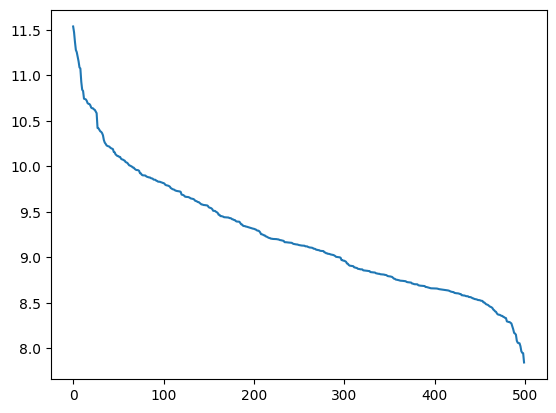

In [100]:
plt.plot(-np.sort(-word_entropy,axis=0))

## 5. Clean Text

- Now creates a new column named 'clean_text' in the DataFrame df and assigns the values from the preprocessed_reviews list to this column. The preprocessed_reviews list seems to contain preprocessed text data, possibly cleaned and tokenized.


- then reorders the columns in the DataFrame, selecting only the 'Time', 'clean_text', and 'Score' columns and updating the DataFrame with this new selection.

In [ ]:
#combining required columns
df['clean_text'] = preprocessed_reviews
df = df[['Time','clean_text','Score']]
#reseting index
df = df.reset_index(drop=True) # The drop=True parameter is used to discard the old index column.
#saving processed file
df.to_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/processed_df.csv',index=False)

In [ ]:
# Reading the preprocessed file
df = pd.read_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/processed_df.csv')
print(df.shape)
df.head()

In [ ]:
df.info()

In [ ]:
df.clean_text.isnull().any()

In [ ]:
missing_indices = df[df['clean_text'].isnull()].index
print(missing_indices)

In [ ]:
#one row is empty.we will drop it
df = df.dropna(axis=0)
df.shape

In [ ]:
df.isnull().any()

In [ ]:
df.info()

Analyzing text data over time is crucial for gaining insights into evolving patterns, sentiments, and user behaviors. Time provides context for understanding temporal trends, seasonal variations, and the impact of events on language. It also allows for the detection of linguistic shifts, user sentiment changes, and the dynamic evolution of terms. Incorporating a temporal perspective in text analysis enables more accurate predictions, cohort analysis, and a nuanced understanding of how language and sentiments adapt to changing circumstances.

- We are considering **time** beacuse our reviews are developed over time, so splitting based on that makes more sense

In [ ]:
 df = df.sample(100000,random_state=42)

In [ ]:
df.shape

In [ ]:
#sortimg based on time
df['Time'] = pd.to_datetime(df['Time'],unit='s')
df = df.sort_values('Time')
df = df.reset_index(drop=True)

## 6. Splitting data

- Train test split
Once we are done with preprocessing, we will split our data into train and test. We will do splitting after sorting the data based on time as a change in time can influence the reviews.

In [ ]:
X = df['clean_text']
y = df['Score']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)
# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=42)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

In [ ]:
import os

# Specify the full path for the directory
directory_path = 'C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis'
os.makedirs(directory_path + '/saved_feats', exist_ok=True)

In [ ]:
np.save('saved_feats/X_train', X_train)
np.save('saved_feats/y_train', y_train)
np.save('saved_feats/X_test', X_test)
np.save('saved_feats/y_test', y_test)

## 7. Vectorization

**Vectorization** in the context of NLP refers to the process of converting textual data into numerical vectors. It's a crucial step in preparing text data for ML algorithms. Vectorization allows us to represent words, sentences, or documents as numerical vectors, enabling machines to process and analyze textual information.

There are several methods for text vectorization in NLP, such as 

1. Bag_of_Words


2. Term Frequency-Inverse Document Frequency (TF-IDF)


3. Word Embeddings (Word Vectors)


4. Doc2Vec (Paragraph Vectors)


5. Hashing Vectorizer

It's common to experiment with multiple methods to find the one that works best for the  sentiment analysis problem.

but we can start with simplicity: Begin with Bag-of-Words or TF-IDF, especially if our dataset is not extremely large. These methods are simple and can provide good results for sentiment analysis tasks.

# Bag of Words (bow)

In [ ]:
bow = CountVectorizer() # entire vocabulary
bow.fit(X_train) 
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

In [ ]:
#saving bow vectors
import pickle
pickle.dump(X_train_bow, open("saved_feats/X_train_bow","wb"))
pickle.dump(X_test_bow, open("saved_feats/X_test_bow","wb"))
pickle.dump(np.array(bow_features), open("saved_feats/bow_features","wb"))

## Loading saved vectors

In [ ]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))
